### Process Flow Diagram


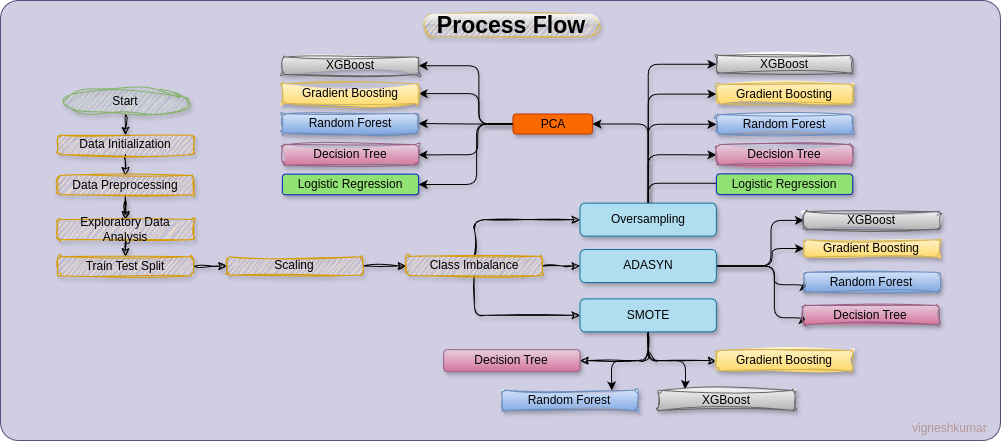

### Initialization

##### <div style="color: #1B5AF4; font-size: 20px;"> 1. Import all necessary libraries. </br> &nbsp;&nbsp;&nbsp;&nbsp;LogisticRegression, Decision Tree classifier, Random Forest, RFE and PCA packages etc

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# %pip install fast_ml    ## Required for constant feature identification package

from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

import xgboost as xgb
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, f1_score, classification_report, accuracy_score

##### <div style="color: #1B5AF4; font-size: 20px;"> 2. Initialize the telecom_churn dataset

In [ ]:
telecom_df = pd.read_csv("./telecom_churn_data.csv")
telecom_df.head(2)

#### Custom Functions

###### <div style="color: #F46F1A; font-size: 20px;">1. Function Combine_features: </br> The below function combines all the features that are part of "Good phase" by stripping the unique identifiers. </br>It then takes the mean among the same features and finally creating a new derived feature.

In [ ]:
def combine_features(df, cols, pat1='_6' , pat2='_7' ,to_append='_good_phase'):
    drop_lst = []
    new_cols = []
    month_col = cols[cols.str.contains(pat='jun_|jul_')].str.replace(pat="(jun_|jul_)", repl="", regex=True).unique()
    cols = cols.str.replace(pat="(_\d$|jun_|jul_)", repl="", regex=True).unique()
    for col in cols:
        if col in month_col:
            new_col = col + to_append
            col1 = 'jun_' + col
            col2 = 'jul_' + col
        else:
            new_col = col + to_append
            col1 = col + pat1
            col2 = col + pat2
            
        df[new_col] = df[[col1, col2]].mean(axis=1)      #############################################  Mean or Median to be decided 
        drop_lst.extend([col1,col2])
        new_cols.extend([new_col])
    return drop_lst, new_cols   

###### <div style="color: #F46F1A; font-size: 20px;">2. Function find_outliers </br>Outlier Analysis using Boxplot IQR method.

In [ ]:
def find_outliers(df):
    temp_df = pd.DataFrame(columns= ['col', 'lower_threshold', 'iqr_q1', 'iqr', 'iqr_q3', 'upper_threshold', 'outliers_cnt'])
    num_cols = df.select_dtypes(include=np.number).columns
    for col in num_cols:
        arr = df[col][df[col].notna()]
        iqr_q3 = np.quantile(df[col], 0.75)
        iqr_q1 = np.quantile(df[col], 0.25)
        
        iqr = iqr_q3 - iqr_q1
        iqr_upper_threshold = iqr_q3 + (1.5 * iqr)
        iqr_lower_threshold = iqr_q1 - (1.5 * iqr)
        
        outliers = arr[(arr > iqr_upper_threshold) | (arr < iqr_lower_threshold)]
        to_add = pd.Series({'col': col, 'lower_threshold': iqr_lower_threshold, 'iqr_q1': iqr_q1, 'iqr': iqr, 'iqr_q3': iqr_q3, 'upper_threshold': iqr_upper_threshold, 'outliers_cnt': len(outliers)})
        temp_df = pd.concat([temp_df,to_add.to_frame().T])
    return temp_df

###### <div style="color: #F46F1A; font-size: 20px;">3. Function check_col_null_pct: </br>Check the columns null percentage and return the columns based on the given threshold value

In [ ]:
def check_col_null_pct(df, thresh=0, incl_all=1):
    col_null_pct = (df.isna().sum()/len(df))*100
    cols_na_abv_thresh = col_null_pct[col_null_pct > thresh]
    cols_na_bel_thresh = col_null_pct[col_null_pct < thresh]
    return cols_na_abv_thresh.sort_values(ascending=False) , cols_na_bel_thresh.sort_values(ascending=False)

### Data Preprocessing

##### <div style="color: #1B5AF4; font-size: 20px;"> 3. Check the shape and size of the dataset.

In [ ]:
telecom_df.size
telecom_df.shape
telecom_df.columns

<div style="color: #019900; ">Observation 1:</div> The size of the data set is 22599774 and the data set contains 226 columns altogether. 

##### <div style="color: #1B5AF4; font-size: 20px;"> 4. Check for any duplicate entries in the data set. Also check if there is any duplicates in mobile number column. 

In [ ]:
telecom_df[telecom_df.duplicated()]
telecom_df['mobile_number'].is_unique  

<div style="color: #019900; "> Observation 2:</div> There are no duplicate row entries in the dataset or in mobile number column

##### <div style="color: #1B5AF4; font-size: 20px;"> 5. Check for column null percentage. 

In [ ]:
cols_with_gt40_na , cols_with_le40_na = check_col_null_pct(telecom_df, 40)
len(cols_with_gt40_na)

<div style="color: #019900; "> Observation 3:</div>  <li>There are 40 columns that have null percentage greater than 40%. Since these columns have high percentage of null values, we decide to drop these features.</li>

In [ ]:
telecom_df = telecom_df[cols_with_le40_na.index.sort_values(ascending=True)]
cols_with_le40_na[cols_with_le40_na > 0]

<div style="color: #019900; "> Observation 4:</div> After dropping features that have more than 40% null values. We could see that there are still 126 columns that have some null values. Therefore, we have to impute those missing values. 

In [ ]:
telecom_df.head(2)

##### <div style="color: #1B5AF4; font-size: 20px;"> 6. Check for any constant features or feature that has only one value.

In [ ]:
from fast_ml import feature_selection as fs

const_features_df = fs.get_constant_features(telecom_df, threshold=100, dropna=True)
const_features_df

<div style="color: #019900; "> Observation 5: 
<li>The following features all have constant values:
<ul>circle_id, last_date_of_month_6, last_date_of_month_7, last_date_of_month_8, last_date_of_month_9, loc_ic_t2o_mou, loc_og_t2o_mou, std_ic_t2o_mou_6, std_ic_t2o_mou_7, std_ic_t2o_mou_8, std_ic_t2o_mou_9, std_og_t2c_mou_6, std_og_t2c_mou_7, std_og_t2c_mou_8, std_og_t2c_mou_9, std_og_t2o_mou</ul>
<li> These constant features add little value to the model, hence we drop those features.</div>

In [ ]:
telecom_df = telecom_df.drop(const_features_df['Var'].to_list(), axis=1)
telecom_df.shape

##### <div style="color: #1B5AF4; font-size: 20px;">7. Plot the bar chart for columns with less than 10% of NULL values. 

In [ ]:
_,cols_with_le10_na = check_col_null_pct(telecom_df, 10)
plt.figure(figsize=(30,2))
cols_with_le10_na[(cols_with_le10_na > 0)].plot.bar()
plt.show();

##### <div style="color: #1B5AF4; font-size: 20px;"> 8. Convert Date column to day in numbers format.

In [ ]:
telecom_df[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']] = telecom_df[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']].apply(lambda x: pd.to_datetime(x).dt.day)

##### <div style="color: #1B5AF4; font-size: 20px;"> 9. Check for any outliers in the data set. 

In [ ]:
find_outliers(telecom_df).sort_values(by=['outliers_cnt'], ascending=False).head(20)

<div style="color: #019900; "> Observation 6: <li>There are outliers in the dataset. But due to high class imbalance, We therefore decide not to cap new outliers as it may have impact on our Model metrics.</li></div>  

##### <div style="color: #1B5AF4; font-size: 20px;"> 10. Impute Missing Values: <li>Since there are lot of missing values in the dataset, we therefore decide to impute it. </br> <li>Also most of the columns are skewed, hence we use "median" as a strategy to impute it. </li>

In [ ]:
telecom_df_bk = telecom_df.copy()
# telecom_df = telecom_df_bk

to_impute_df = telecom_df.select_dtypes(include = np.number)

si = SimpleImputer(strategy='median')
imputed_arr = si.fit_transform(to_impute_df)
df_imputed = pd.DataFrame(imputed_arr, columns = to_impute_df.columns)

telecom_df = telecom_df[telecom_df.columns.difference(to_impute_df.columns)]
telecom_df = pd.concat([telecom_df, df_imputed], axis=1)
telecom_df 

##### <div style="color: #1B5AF4; font-size: 20px;"> 11. Filter the high value customers who have recharged more than 70% of the average recharge value during the good phase. 

In [ ]:
# telecom_df['total_rech_amt_good_phase'] = telecom_df[['total_rech_amt_6','total_rech_amt_7']].sum(axis=1)
# telecom_df = telecom_df.drop(['total_rech_amt_6','total_rech_amt_7'], axis=1)
# telecom_df = telecom_df[(telecom_df['total_rech_amt_good_phase'] >= telecom_df['total_rech_amt_good_phase'].quantile(0.7))]

In [ ]:
telecom_df['total_rech_amt_good_phase']  = telecom_df[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
telecom_df = telecom_df.drop(['total_rech_amt_6','total_rech_amt_7'], axis=1)
telecom_df = telecom_df[(telecom_df['total_rech_amt_good_phase'] >= telecom_df['total_rech_amt_good_phase'].quantile(0.7))]

<div style="color: #019900; "> Observation 6:
After filtering the high value customers, we could notice the dataset is now reduced to ~30k rows </div>

##### <div style="color: #1B5AF4; font-size: 20px;"> 12. Tag the churned customers (1 or 0) by applying conditions on the following fourth month columns: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

In [ ]:
telecom_df['churn'] = telecom_df.apply(lambda x: 1 if ((x['total_ic_mou_9'] < 1) & (x['total_og_mou_9'] < 1) & (x['vol_2g_mb_9'] < 1 ) & (x['vol_3g_mb_9'] < 1) )  else  0, axis=1)

##### <div style="color: #1B5AF4; font-size: 20px;"> 13. Rename columns_8 as action phase based on business requirements.  

In [ ]:
telecom_df.columns = telecom_df.columns.str.replace(pat='_8',repl='_action_phase')
telecom_df = telecom_df.rename(columns={'aug_vbc_3g': 'vbc_3g_action_phase'})
telecom_df.filter(like='_8').columns
telecom_df.shape

##### <div style="color: #1B5AF4; font-size: 20px;"> 14. Find all columns related to churn phase or cols with _9 in name. and drop it

In [ ]:
sep_cols_to_drop = telecom_df.filter(like='_9').columns.to_list()
sep_cols_to_drop.append('sep_vbc_3g')
sep_cols_to_drop

In [ ]:
telecom_df = telecom_df.drop(sep_cols_to_drop, axis=1)
telecom_df.shape

<div style="color: #019900; "> Observation 7:
After dropping the churn phase columns. We could now notice that the number of columns have been reduced to 131. </div>

##### <div style="color: #1B5AF4; font-size: 20px;"> 15. Filter features that are identified by months _6 & _7, in order to combine those features as "good phase" and also check the datatypes 

In [ ]:
cols_to_combine =  telecom_df.filter(regex='.*(jun_|jul_|_6|_7).*',axis=1).columns
telecom_df[cols_to_combine].info()

##### <div style="color: #1B5AF4; font-size: 20px;"> 16. Now that we have identified the features for "Good phase", using an aggr method we can go ahead combine those features. </br><li>once features are combined as "Good Phase", we drop all those redundant features of months _6&_7. 

In [ ]:
drop_lst, new_cols = combine_features(df=telecom_df, cols=cols_to_combine, pat1='_6', pat2='_7',to_append='_good_phase')
telecom_df = telecom_df.drop(drop_lst, axis=1)
telecom_df.shape
telecom_df.columns

In [ ]:
cols_with_null,_ = check_col_null_pct(telecom_df)
cols_with_null

<div style="color: #019900; "> Observation 8:
The total no of columns are now reduced to 91 and all the null values are imputed</div>

In [ ]:
telecom_df = telecom_df.drop('mobile_number', axis=1)

### Exploratory Data Analysis

In [ ]:
cols = telecom_df.select_dtypes(include=np.number).columns
fig, axs = plt.subplots(int(np.ceil(len(cols)/10)),10, figsize=(30, int(np.ceil(len(cols)/10))*2))

for idx, col in enumerate(cols):
    t1 = axs.flatten()[idx]
    t1.hist(telecom_df[col])
    t1.set_title(col)

plt.tight_layout()
plt.show();

In [ ]:
corr_df = telecom_df[telecom_df.select_dtypes(include=np.number).columns].corr()
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
fig, axs = plt.subplots(figsize=(15,10))
with sns.axes_style('white'):
    axs = sns.heatmap(corr_df, mask=mask, square=True)

In [ ]:
corr_df = telecom_df.corr(numeric_only=True).abs()
corr_df = corr_df.unstack()
correlation = corr_df.sort_values()
correlation = corr_df.dropna()

correlation = correlation [correlation  != 1.0]
correlation = correlation .reset_index()
correlation.sort_values(by=0, ascending=False).head(20)

In [ ]:
sns.boxplot(telecom_df['aon'],orient='vert',palette='Set1')

In [ ]:
per = telecom_df['aon'].quantile([0.05,0.95]).values

In [ ]:
# Remove Outlier
#telecom_df['aon'][telecom_df['aon'] <= per[0]] = per[0]
telecom_df['aon'][telecom_df['aon'] >= per[1]] = per[1]

In [ ]:
telecom_df.info()

In [ ]:
telecom_df.describe()

In [ ]:
for column in telecom_df.columns:
    plt.figure(figsize=(6, 4))
    sns.displot(telecom_df, x=column, kind="hist", kde=True)
    #sns.boxplot(data=telecom_df[column])
    plt.title(f'Box plot for {column}')
    plt.show()

## Observations
- AON : New user are high in no
- ARPU : Avergae revenue is sigma curve and around 700 is mid
- date_of _last_rech_action_phase, date_of_last_rech_good_phase: No of recharge are higher in end of the month
- isd_ic_mou, isd_og_mou: ISD calls are less in no, so many users call duration is nearly 0
- last_day_rch_amt : Mostly 100 rs recharge people do on last day
- loc_ic_mou_action_phase : Most of the people call 100 mins locally
- max_rech_amt_action_phase : Max reachrge ammount avergae customer do is 100-150 rs
- monthly_2g_action_phase : Most of the users 2 g usage is very small
- monthly_3g_action_phase : Most of the users 3 g usage is very small
- Local calls are more in no than calls to other operatos
- Roming usage is also small

In [ ]:
# Multivariant analysis
for column in telecom_df.columns:
    plt.figure(figsize=(6, 4))
    sns.displot(telecom_df, x=column,hue='churn', kind="hist", kde=True)
    #sns.boxplot(data=telecom_df[column])
    plt.title(f'Box plot for {column}')
    plt.show()

## Observations
- Churn rate decreases significantly over age of customer
- Chrun rate is very less for customers having arpu more than 1000
- Churn rate is more for users doing recharge in 22-28 date
- last_day_rch_amt_action_phase : Churn rate is higher for lesser ammount
- Churn rate is higher for less usagage user like incoming calls, outgoing calls
- max_rech_amt_action_phase : For lower recharge ammount churn rate is higher
- total_rech_amt_action_phase : For lower recharge ammount churn rate is higher
- date_of_last_rech_good_phase : Churn rate pattern is different than action phase
- last_day_rch_amt_good_phase : Pattern is same like action phase

In [ ]:
# telecom_df.to_csv('test.csv')

### Train and Test Split

In [ ]:
X = telecom_df.drop('churn', axis=1)
y = telecom_df['churn']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=100)

### Scaling

In [ ]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train, y_train)
X_train

X_test[X_test.columns] = scaler.transform(X_test)

### Class Imbalance

In [ ]:
# telecom_df.to_csv('test.csv')
telecom_df['churn'].sum()/len(telecom_df['churn'])*100

In [ ]:
X_train_ori, y_train_ori = X_train.copy(), y_train.copy()

#### Custom Function for Class Imbalance

In [ ]:
def handle_imbalance(X_tr, y_tr, technique='oversampling', random_state=100):
    if technique == 'undersampling':
        under_sample = RandomUnderSampler(random_state=random_state, sampling_strategy='majority')
        # print(under_sample.get_params())
        # print(under_sample._sampling_strategy_docstring)
        X_train_udr, y_train_udr = under_sample.fit_resample(X_tr, y_tr)
        return X_train_udr, y_train_udr
    elif technique == 'tomek_links':
        tomek_sample = TomekLinks()
        # print(tomek_sample.get_params())
        # print(tomek_sample._sampling_strategy_docstring)
        X_train_tomek, y_train_tomek = tomek_sample.fit_resample(X_tr, y_tr)
        return X_train_tomek, y_train_tomek
    elif technique == 'oversampling':
        over_sample = RandomOverSampler(random_state=random_state)
        # print(over_sample.get_params())
        # print(over_sample._sampling_strategy_docstring)
        X_train_ovr, y_train_ovr = over_sample.fit_resample(X_tr, y_tr)
        return X_train_ovr, y_train_ovr
    elif technique == 'smote':
        smote_sample = SMOTE(random_state=random_state, k_neighbors=5)
        # print(smote_sample.get_params())
        # print(smote_sample._sampling_strategy_docstring)
        X_train_smote, y_train_smote = smote_sample.fit_resample(X_tr, y_tr)
        return X_train_smote, y_train_smote
    elif technique == 'adasyn':
        adasyn_sample = ADASYN(random_state=random_state, n_neighbors=5)
        # print(adasyn_sample.get_params())
        # print(adasyn_sample._sampling_strategy_docstring)
        X_train_adasyn, y_train_adasyn = adasyn_sample.fit_resample(X_tr, y_tr)
        return X_train_adasyn, y_train_adasyn
    elif technique == 'smote_tomek':
        smote_tomek_sample = SMOTETomek(random_state=random_state)
        # print(smote_tomek_sample.get_params())
        X_train_smote_tomek, y_train_smote_tomek = smote_tomek_sample.fit_resample(X_tr, y_tr)
        return X_train_smote_tomek, y_train_smote_tomek

####  Class Imbalance using Oversampling

In [ ]:
X_train_ovr, y_train_ovr = handle_imbalance(X_train_ori, y_train_ori, technique='oversampling', random_state=100)
sum(y_train_ovr)/len(y_train_ovr)*100
sorted(Counter(y_train_ovr).items())

####  Class Imbalance using SMOTE

In [ ]:
X_train_smote, y_train_smote = handle_imbalance(X_train_ori, y_train_ori, technique='smote', random_state=100)
sum(y_train_smote)/len(y_train_smote)*100
sorted(Counter(y_train_smote).items())

####  Class Imbalance using ADASYN

In [ ]:
X_train_adasyn, y_train_adasyn = handle_imbalance(X_train_ori, y_train_ori, technique='adasyn', random_state=100)
sum(y_train_adasyn)/len(y_train_adasyn)*100
sorted(Counter(y_train_adasyn).items())

### ----------------------------------

### Principal Component Analysis

In [ ]:
def principal_component_analysis(X_tr, random_state=100):
    pca = PCA(random_state=random_state)
    pca.fit(X_tr)

    var_ratio_df = pd.DataFrame({'feature':X_tr.columns, 'var_ratio': pca.explained_variance_ratio_})
    components = pd.DataFrame(pca.components_)
    var_ratio_df = pd.concat([var_ratio_df,components],axis=1)
    var_ratio_df.head()
    
    fig, axs = plt.subplots(1,3, figsize=(25,5))
    axs[0].bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
    axs[0].set_xlabel('Component number')
    axs[0].set_ylabel('Explained variance ratio')
    axs[0].set_title('Bar plot')

    axs[1].plot(pca.explained_variance_ratio_)
    axs[1].set_xlabel('Component number')
    axs[1].set_ylabel('Explained variance ratio')
    axs[1].set_title('Scree plot')

    var_cumu = np.cumsum(pca.explained_variance_ratio_) 
    axs[2].vlines(x=47, ymax=1, ymin=0, colors="r", linestyles="--")
    axs[2].hlines(y=0.95, xmax=100, xmin=0, colors="g", linestyles="--")
    axs[2].plot(var_cumu)
    axs[2].set_ylabel("Cumulative variance explained")
    axs[2].set_xlabel('Component number')
    plt.show();
    
def incremental_pca(X_tr, X_te, n_components=45):
    pca_incremental = IncrementalPCA(n_components, )
    pca_incremental.fit(X_tr)

    # Retrieve the principal components
    principal_components = pca_incremental.components_
    feature_names = X_tr.columns

    # Calculate the overall importance of each feature
    feature_importance = {}
    for i, component in enumerate(principal_components):
        for j, weight in enumerate(component):
            if feature_names[j] not in feature_importance:
                feature_importance[feature_names[j]] = 0.0
            feature_importance[feature_names[j]] += abs(weight)

    # Sort features by their overall importance
    sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    feature_lst = []
    for feature, importance in sorted_feature_importance[:10]:
        feature_lst.append(f"{feature}: {importance}")

    df_tr_pca = pca_incremental.fit_transform(X_tr)
    df_te_pca = pca_incremental.transform(X_te)
    
    return df_tr_pca, df_te_pca, feature_names, feature_lst

#### PCA after using class imbalance techniques

In [ ]:
print("PCA using Random Oversampling")
X_train , y_train = X_train_ovr, y_train_ovr 
principal_component_analysis(X_train, random_state=100)
df_train_ovr_pca, df_test_ovr_pca, feature_names, feature_lst = incremental_pca(X_train, X_test, n_components=45)

print("PCA using SMOTE")
X_train , y_train = X_train_smote, y_train_smote 
principal_component_analysis(X_train, random_state=100)
df_train_smote_pca, df_test_smote_pca, feature_names, feature_lst = incremental_pca(X_train, X_test, n_components=45)

print("PCA using ADASYN")
X_train , y_train = X_train_adasyn, y_train_adasyn 
principal_component_analysis(X_train, random_state=100)
df_train_adasyn_pca, df_test_adasyn_pca, feature_names, feature_lst = incremental_pca(X_train, X_test, n_components=45)

### ----------------------------------

### Machine Learning - Algorithms and Models 

####  Custom Functions for Model Building

In [ ]:
def model_training(fXt, fyt, fcutoff, ftest=False, fres=None):
    fXt_sm = sm.add_constant(fXt)
    
    if ftest == False:
        lrm = sm.GLM(fyt, fXt_sm, family=sm.families.Binomial())
        lrm = lrm.fit()
        fyt_pred = lrm.predict(fXt_sm)
    else:
        lrm = fres
        fyt_pred = lrm.predict(fXt_sm)
        
    fyt_pred = fyt_pred.values.reshape(-1)
    fyt_pred_final = pd.DataFrame({'Converted': fyt.values, 'Conv_Prob': fyt_pred})
    fyt_pred_final['ID'] = fyt.index
    fyt_pred_final['predicted'] = fyt_pred_final.Conv_Prob.map(lambda x: 1 if x > fcutoff else 0)
    return lrm, fyt_pred, fyt_pred_final

def logreg_metrics_fn(fyt_pred_final):
    fconfusion = confusion_matrix(fyt_pred_final.Converted, fyt_pred_final.predicted )
    faccuracy = accuracy_score(fyt_pred_final.Converted, fyt_pred_final.predicted)
    
    TP = fconfusion[1,1] # true positive 
    TN = fconfusion[0,0] # true negatives
    FP = fconfusion[0,1] # false positives
    FN = fconfusion[1,0] # false negatives
    
    fSensi  = TP/(TP+FN) # Calculate the sensitivity
    fSpeci  = TN/(TN+FP) # Calculate the specificity
    fPreci  = TP/(TP+FP) # Calculate Precision
    fRecal  = TP/(TP+FN) # Calculate Recall
       
    return fconfusion, faccuracy, fSensi, fSpeci, fPreci, fRecal

def get_vif_score(fXt, cl):
    vif = pd.DataFrame()
    vif['Features'] = fXt[cl].columns
    vif['VIF'] = [variance_inflation_factor(fXt[cl].values, i) for i in range(fXt[cl].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def generate_metrics(yt, yt_pred, yt_prob ):
    accuracy = accuracy_score(yt, yt_pred,  )
    f1_sc = f1_score(yt, yt_pred,  )
    recall = recall_score(yt, yt_pred,  )
    precision = precision_score(yt, yt_pred,  )
    roc_score = roc_auc_score(yt, yt_prob)
    cl_rep = classification_report(yt, yt_pred)
    conf_mat = confusion_matrix(yt, yt_pred)
    df = pd.DataFrame({"accuracy":[accuracy],"roc_score":[roc_score],"precision":[precision],"recall":[recall],"f1_score":[f1_sc], 
                       "classification_report":[cl_rep], "confusion_matrix": [conf_mat]})
    return df, accuracy,roc_score, precision,recall, f1_sc, cl_rep, conf_mat

def generate_summary_report(df=None, model_name="", class_imb='', train_accuracy="", test_accuracy="", roc_score="", precision="", recall="", f1_score="", classification_rep="", conf_matrix="", step='create'):
    if step == 'create':
        df = pd.DataFrame(columns=["model_name","class_imb","train_accuracy","test_accuracy","roc_score","precision","recall","f1_score", "classification_report", "confusion_matrix"])
        return df
    elif step == 'add': 
        df.loc[len(df)] = pd.Series({"model_name": model_name,"class_imb":class_imb,"train_accuracy": train_accuracy, "test_accuracy": test_accuracy,"roc_score": roc_score,"precision": precision,"recall": recall,"f1_score":f1_score, "classification_report": classification_rep, "confusion_matrix": conf_matrix})
        return df

#### Logistic Regression - RFE

##### Model Building

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr

logreg = LogisticRegression()
logreg = logreg.fit(X_train,y_train)

In [ ]:
rfecv = RFECV(estimator=logreg, cv=5)
rfecv.fit(X_train, y_train)

In [ ]:
rfecv.cv_results_['mean_test_score']
plt.figure(figsize=[10, 5])
plt.plot(range(1, len(X_train.columns)+1), rfecv.cv_results_['mean_test_score'])
plt.show();

In [ ]:
rfe = RFE(estimator=logreg, n_features_to_select= 15) 
rfe = rfe.fit(X_train, y_train)

cols = rfe.get_feature_names_out()
rfe_df = pd.DataFrame({'feature':X_train.columns, 'rank': rfe.ranking_ , 'support': rfe.support_})
rfe_df.sort_values(by='rank', ascending=True).head(15)

In [ ]:
logreg = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial())
logreg = logreg.fit()
# logreg.summary()

In [ ]:
logreg1, y_train_pred, y_train_pred_final = model_training(X_train[cols], y_train, 0.5)
logreg1.pvalues.sort_values(ascending=False).head()

vif_scores = get_vif_score(X_train, cols)
vif_scores[vif_scores['VIF'] > 5].head()

In [ ]:
cols = list(cols)
cols.remove('total_ic_mou_good_phase')

logreg2, y_train_pred, y_train_pred_final = model_training(X_train[cols], y_train, 0.5)
logreg2.pvalues.sort_values(ascending=False).head()

vif_scores = get_vif_score(X_train,cols)
vif_scores[vif_scores['VIF'] > 5].head()

In [ ]:
cols.remove('total_ic_mou_action_phase')

logreg3, y_train_pred, y_train_pred_final = model_training(X_train[cols], y_train, 0.5)
logreg3.pvalues.sort_values(ascending=False).head()

vif_scores = get_vif_score(X_train,cols)
vif_scores[vif_scores['VIF'] > 5].head()

In [ ]:
cols.remove('total_og_mou_good_phase')

logreg4, y_train_pred, y_train_pred_final = model_training(X_train[cols], y_train, 0.5)
logreg4.pvalues.sort_values(ascending=False).head()

vif_scores = get_vif_score(X_train,cols)
vif_scores[vif_scores['VIF'] > 5].head()

In [ ]:
logreg5, y_train_pred, y_train_pred_final = model_training(X_train[cols], y_train, 0.5)
logreg5.pvalues.sort_values(ascending=False).head()

vif_scores = get_vif_score(X_train,cols)
vif_scores.head()

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conv_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head(2)

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci', 'recall'])
for i in numbers:
    cm1 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, preci, recall]
    
cutoff_df

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(25,6))

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], ax=axs[0])
axs[0].set_title('Accuracy Sensitivity Specificity')
axs[0].vlines( ymin=0, ymax=0.9,x=0.537, color="r")

# created a function for the ROC curve creation and see the labels 
RocCurveDisplay.from_predictions(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob, drop_intermediate=False, ax=axs[1 ])
axs[1].set_title('ROC curve')

# plotting Precision and Recall curve and finding the cutoff for this.
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conv_Prob)
axs[2].plot(thresholds, p[:-1], "b")
axs[2].plot(thresholds, r[:-1], "r")
axs[2].set_title('Precision Recall Curve')
axs[2].vlines( ymin=0, ymax=0.9,x=0.54, color="r")
plt.show();

In [ ]:
# used the cutoff value from accuracy sensitivity and specificity curve to see the prediction on train dataset.
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.537 else 0)
y_train_pred_final.head()

# Let's check the overall accuracy.
cf_matrix, train_accuracy, sensitivity, specificity, precision, recall = logreg_metrics_fn(y_train_pred_final)
print(f'Train Accuracy - {round(train_accuracy,3)}\nSensitivity - {round(sensitivity,3)}\nspecificity - {round(specificity,3)}\nPrecision - {round(precision,3)}\nRecall - {round(recall,3)}')

In [ ]:
# used the cutoff value from precision -recall curve to see the prediction on train dataset.
y_train_pred_final['final_predicted'] = y_train_pred_final.Conv_Prob.map( lambda x: 1 if x > 0.54 else 0)
y_train_pred_final.head()

# Let's check the overall accuracy. 
cf_matrix, train_accuracy,sensitivity, specificity, precision, recall = logreg_metrics_fn(y_train_pred_final)
print(f'Train Accuracy - {round(train_accuracy,3)}\nSensitivity - {round(sensitivity,3)}\nspecificity - {round(specificity,3)}\nPrecision - {round(precision,3)}\nRecall - {round(recall,3)}')

##### Model Testing

In [ ]:
logregp, y_test_pred, y_test_pred_final = model_training(X_test[cols], y_test, 0.54, True, logreg5)

cf_matrix, test_accuracy, sensitivity, specificity, precision, recall = logreg_metrics_fn(y_test_pred_final)
roc_score = roc_auc_score( y_test_pred_final.Converted, y_test_pred_final.Conv_Prob )
f1_sc = f1_score(y_test, y_test_pred_final.predicted)

print(f'Test Accuracy - {round(test_accuracy,3)}\nROC Score - {round(roc_score,3)}\nSensitivity - {round(sensitivity,3)}\nSpecificity - {round(specificity,3)}\nPrecision - {round(precision,3)}\nRecall - {round(recall,3)}')

overall_summary_df = generate_summary_report()
overall_summary_df = generate_summary_report(df=overall_summary_df, model_name="LogisticRegression",class_imb='oversampling', train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                             precision=precision, recall=recall, f1_score=f1_sc, classification_rep="-", conf_matrix=cf_matrix, step='add')

#### Logistic Regression - PCA

In [ ]:
### LogisticRegressionClassifier
def logistic_regression(df_train_pca, df_test_pca, y_train, y_test, overall_summary_df):
    lr_pca = LogisticRegressionCV(cv=10, random_state=100)
    lr_pca.fit(df_train_pca, y_train)

    lr_pca_ytrain_prob = lr_pca.predict_proba(df_train_pca)[:,1]
    lr_pca_ytrain_pred = lr_pca.predict(df_train_pca)

    lr_pca_ytest_prob = lr_pca.predict_proba(df_test_pca)[:,1]
    lr_pca_ytest_pred = lr_pca.predict(df_test_pca)

    _, train_accuracy, _, _, _, _, _, _ = generate_metrics(y_train, yt_pred=lr_pca_ytrain_pred, yt_prob=lr_pca_ytrain_prob)
    metrics_df, test_accuracy, roc_score, precision,recall, f1_sc, class_report, conf_matrix = generate_metrics(y_test, yt_pred=lr_pca_ytest_pred, yt_prob=lr_pca_ytest_prob)
    print(metrics_df)

    overall_summary_df = generate_summary_report(df=overall_summary_df, model_name="LogisticRegressionPCA",class_imb='oversampling', train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                                precision=precision, recall=recall, f1_score=f1_sc, classification_rep=class_report, conf_matrix=conf_matrix, step='add')

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr 
logistic_regression(df_train_ovr_pca, df_test_ovr_pca, y_train, y_test, overall_summary_df = overall_summary_df)

#### DecisionTreeClassifier

In [ ]:
# Decision Trees - Base 
def decision_tree_classifier(X_train, y_train, X_test, y_test, technique, overall_summary_df):
    dtc = DecisionTreeClassifier(random_state=100, max_depth=6)
    dtc = dtc.fit(X_train, y_train)

    # Get feature importance
    dtc_feature_importances = dtc.feature_importances_
    if X_train.shape[1] == len(X.columns):
        model_name="DecisionTreeClassifier"
        dtc_feature_imp_df = pd.DataFrame({'columns':X.columns, 'imp_score': dtc_feature_importances})
    else:
        model_name="DecisionTreeClassifierPCA"
        dtc_feature_imp_df = pd.DataFrame({'principal_component': range(len(dtc_feature_importances)), 'imp_score': dtc_feature_importances})
    dtc_feature_imp_df.sort_values(by='imp_score', ascending=False).head(5)

    y_train_prob_dtc = dtc.predict_proba(X_train)[:, 1]
    y_train_pred_dtc = dtc.predict(X_train)

    y_test_prob_dtc = dtc.predict_proba(X_test)[:, 1]
    y_test_pred_dtc = dtc.predict(X_test)

    _, train_accuracy, _, _, _, _, _, _ = generate_metrics(y_train, yt_pred=y_train_pred_dtc, yt_prob=y_train_prob_dtc)
    metrics_df, test_accuracy, roc_score, precision,recall, f1_sc, class_report, conf_matrix = generate_metrics(y_test, yt_pred=y_test_pred_dtc, yt_prob=y_test_prob_dtc)
    print(metrics_df)
    
    overall_summary_df = generate_summary_report(df=overall_summary_df, model_name=model_name, class_imb=technique, train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                                precision=precision, recall=recall, f1_score=f1_sc, classification_rep =class_report, conf_matrix=conf_matrix, step='add')

##### DT - Oversampling

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr
decision_tree_classifier(X_train, y_train, X_test, y_test,  technique='oversampling', overall_summary_df=overall_summary_df)

##### DT - SMOTE

In [ ]:
X_train, y_train = X_train_smote, y_train_smote
decision_tree_classifier(X_train, y_train, X_test, y_test, technique='smote', overall_summary_df=overall_summary_df)

##### DT - ADASYN

In [ ]:
X_train, y_train = X_train_adasyn, y_train_adasyn
decision_tree_classifier(X_train, y_train, X_test, y_test, technique='adasyn', overall_summary_df=overall_summary_df)

#### Decision Tree - PCA

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr 
decision_tree_classifier(df_train_ovr_pca, y_train, df_test_ovr_pca, y_test, technique='oversampling', overall_summary_df=overall_summary_df)

#### RandomForestClassifier

In [ ]:
def random_forest_classifier(X_train, y_train, X_test, y_test, technique, overall_summary_df):
    rf = RandomForestClassifier(random_state=100, oob_score=True, max_depth=6)
    rf.fit(X_train, y_train)

    # Get feature importance
    rf_feature_importances = rf.feature_importances_
    if X_train.shape[1] == len(X.columns):
        model_name="RandomForestClassifier"
        rf_feature_imp_df = pd.DataFrame({'columns':X.columns, 'imp_score': rf_feature_importances})
    else:
        model_name="RandomForestClassifierPCA"
        rf_feature_imp_df = pd.DataFrame({'principal_component': range(len(rf_feature_importances)), 'imp_score': rf_feature_importances})
    rf_feature_imp_df.sort_values(by='imp_score', ascending=False).head(10)

    rf_ytrain_prob = rf.predict_proba(X_train)[:, 1]
    rf_ytrain_pred = rf.predict(X_train)

    rf_ytest_prob = rf.predict_proba(X_test)[:, 1]
    rf_ytest_pred = rf.predict(X_test)

    _, train_accuracy, _, _, _, _, _, _ = generate_metrics(y_train, yt_pred=rf_ytrain_pred, yt_prob=rf_ytrain_prob)
    metrics_df, test_accuracy, roc_score, precision,recall, f1_sc, class_report, conf_matrix = generate_metrics(y_test, yt_pred=rf_ytest_pred, yt_prob=rf_ytest_prob)
    print(metrics_df)

    overall_summary_df = generate_summary_report(df=overall_summary_df, model_name=model_name,class_imb=technique, train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                                precision=precision, recall=recall, f1_score=f1_sc, classification_rep=class_report, conf_matrix=conf_matrix, step='add')

##### Random Forest - Oversampling

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr
random_forest_classifier(X_train, y_train, X_test, y_test,  technique='oversampling', overall_summary_df=overall_summary_df)

##### Random Forest - SMOTE

In [ ]:
X_train, y_train = X_train_smote, y_train_smote
random_forest_classifier(X_train, y_train, X_test, y_test, technique='smote', overall_summary_df=overall_summary_df)

##### Random Forest - ADASYN

In [ ]:
X_train, y_train = X_train_adasyn, y_train_adasyn
random_forest_classifier(X_train, y_train, X_test, y_test, technique='adasyn', overall_summary_df=overall_summary_df)

#### Random Forest - PCA

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr 
random_forest_classifier(df_train_ovr_pca, y_train, df_test_ovr_pca, y_test, technique='oversampling', overall_summary_df=overall_summary_df)

#### GradientBoostingClassifier

In [ ]:
def gradient_boosting_classifier(X_train, y_train, X_test, y_test, technique, overall_summary_df):
    gbc = GradientBoostingClassifier(random_state=100, max_depth=6)
    gbc.fit(X_train, y_train)

    # Get feature importance
    gbc_feature_importances = gbc.feature_importances_
    if X_train.shape[1] == len(X.columns):
        model_name="GradientBoostingClassifier"
        gbc_feature_imp_df = pd.DataFrame({'columns':X.columns, 'imp_score': gbc_feature_importances})
    else:
        model_name="GradientBoostingClassifierPCA"
        gbc_feature_imp_df = pd.DataFrame({'principal_component': range(len(gbc_feature_importances)), 'imp_score': gbc_feature_importances})    
    gbc_feature_imp_df.sort_values(by='imp_score', ascending=False).head(10)

    gbc_ytrain_prob = gbc.predict_proba(X_train)[:, 1]
    gbc_ytrain_pred = gbc.predict(X_train)

    gbc_ytest_prob = gbc.predict_proba(X_test)[:, 1]
    gbc_ytest_pred = gbc.predict(X_test)

    _, train_accuracy, _, _, _, _, _, _ = generate_metrics(y_train, yt_pred=gbc_ytrain_pred, yt_prob=gbc_ytrain_prob)
    metrics_df, test_accuracy, roc_score, precision,recall, f1_sc, class_report, conf_matrix = generate_metrics(y_test, yt_pred=gbc_ytest_pred, yt_prob=gbc_ytest_prob)
    print(metrics_df)

    overall_summary_df = generate_summary_report(df=overall_summary_df, model_name=model_name, class_imb=technique, train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                                precision=precision, recall=recall, f1_score=f1_sc, classification_rep=class_report, conf_matrix=conf_matrix, step='add')    

##### Gradient Boosting - Oversampling

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr
gradient_boosting_classifier(X_train, y_train, X_test, y_test, technique='oversampling', overall_summary_df=overall_summary_df)

##### Gradient Boosting - SMOTE

In [ ]:
X_train, y_train = X_train_smote, y_train_smote
gradient_boosting_classifier(X_train, y_train, X_test, y_test, technique='smote', overall_summary_df=overall_summary_df)

##### Gradient Boosting - ADASYN

In [ ]:
X_train, y_train = X_train_adasyn, y_train_adasyn
gradient_boosting_classifier(X_train, y_train, X_test, y_test, technique='adasyn', overall_summary_df=overall_summary_df)

#### Gradient Boosting - PCA

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr 
gradient_boosting_classifier(df_train_ovr_pca, y_train, df_test_ovr_pca, y_test, technique='oversampling', overall_summary_df=overall_summary_df)

#### XGBoostClassifier

In [ ]:
def xgb_classifier(X_train, y_train, X_test, y_test, technique, overall_summary_df):
    xgb_cfl =  xgb.XGBClassifier(scale_pos_weight= 1, objective = 'binary:logistic', random_state= 100, max_depth=6)
    xgb_cfl.fit(X_train, y_train)

    # Get feature importance
    xgb_feature_importances = xgb_cfl.feature_importances_
    if X_train.shape[1] == len(X.columns):
        model_name="XGBClassifier"
        xgb_feature_imp_df = pd.DataFrame({'columns':X.columns, 'imp_score': xgb_feature_importances})
    else:
        model_name="XGBClassifierPCA"
        xgb_feature_imp_df = pd.DataFrame({'principal_component': range(len(xgb_feature_importances)), 'imp_score': xgb_feature_importances}) 
    xgb_feature_imp_df.sort_values(by='imp_score', ascending=False).head(10)

    xgb_ytrain_prob = xgb_cfl.predict_proba(X_train)[:, 1]
    xgb_ytrain_pred = xgb_cfl.predict(X_train)

    xgb_ytest_prob = xgb_cfl.predict_proba(X_test)[:, 1]
    xgb_ytest_pred = xgb_cfl.predict(X_test)

    _, train_accuracy, _, _, _, _, _, _ = generate_metrics(y_train, yt_pred=xgb_ytrain_pred, yt_prob=xgb_ytrain_prob)
    metrics_df, test_accuracy, roc_score, precision,recall, f1_sc, class_report, conf_matrix = generate_metrics(y_test, yt_pred=xgb_ytest_pred, yt_prob=xgb_ytest_prob)
    print(metrics_df)

    overall_summary_df = generate_summary_report(df=overall_summary_df, model_name=model_name, class_imb=technique, train_accuracy=train_accuracy, test_accuracy=test_accuracy, roc_score=roc_score, 
                                                precision=precision, recall=recall, f1_score=f1_sc, classification_rep=class_report, conf_matrix=conf_matrix, step='add') 

##### XGBoost - Oversampling

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr
xgb_classifier(X_train, y_train, X_test, y_test,  technique='oversampling', overall_summary_df=overall_summary_df)

##### XGBoost - SMOTE

In [ ]:
X_train, y_train = X_train_smote, y_train_smote
xgb_classifier(X_train, y_train, X_test, y_test, technique='smote', overall_summary_df=overall_summary_df)

##### XGBoost - ADASYN

In [ ]:
X_train, y_train = X_train_adasyn, y_train_adasyn
xgb_classifier(X_train, y_train, X_test, y_test, technique='adasyn', overall_summary_df=overall_summary_df)

#### XGBoost - PCA

In [ ]:
X_train, y_train = X_train_ovr, y_train_ovr 
xgb_classifier(df_train_ovr_pca, y_train, df_test_ovr_pca, y_test, technique='oversampling', overall_summary_df=overall_summary_df)

### Summary

In [ ]:
overall_summary_df 

In [ ]:
overall_summary_df.set_index('model_name').plot.bar(figsize=(30,5))
plt.hlines(xmin=-0.5,xmax=30,y=0.5, color='r',linestyles='--')
plt.xticks(rotation=45)
plt.title('Models Performance Summary')
plt.show();